In [38]:
# === Step 1: Setup and Data Loading ===
import numpy as np
import pandas as pd
from scipy.special import expit
from numpy.linalg import pinv
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Build file path dynamically to point to your Downloads folder
csv_path = Path.home() / "Downloads" / "car_sales_data.csv"

# Load dataset
df = pd.read_csv(csv_path)

# Quick look at data
print("Loaded file from:", csv_path)
print("Dataset shape:", df.shape)
print(df.head())


Loaded file from: C:\Users\lavad\Downloads\car_sales_data.csv
Dataset shape: (50000, 7)
  Manufacturer       Model  Engine size Fuel type  Year of manufacture  \
0         Ford      Fiesta          1.0    Petrol                 2002   
1      Porsche  718 Cayman          4.0    Petrol                 2016   
2         Ford      Mondeo          1.6    Diesel                 2014   
3       Toyota        RAV4          1.8    Hybrid                 1988   
4           VW        Polo          1.0    Petrol                 2006   

   Mileage  Price  
0   127300   3074  
1    57850  49704  
2    39190  24072  
3   210814   1705  
4   127869   4101  


In [39]:
# === Step 2: Data Preparation Helper Functions ===

def _add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def _one_hot(categories):
    cats = np.unique(categories)
    cat_to_idx = {c: i for i, c in enumerate(cats)}
    Z = np.zeros((len(categories), len(cats)), dtype=float)
    for r, c in enumerate(categories):
        Z[r, cat_to_idx[c]] = 1.0
    return Z, cats, cat_to_idx

def _apply_penalty(grad, w, penalty, C, l1_ratio=0.5):
    """Apply regularization to gradient of log-likelihood."""
    if penalty is None or penalty == "none" or C == 0:
        return grad

    g = grad.copy()
    if penalty == "l2":
        g[1:] += -2.0 * C * w[1:]
    elif penalty == "l1":
        g[1:] += -C * np.sign(w[1:])
    elif penalty == "elasticnet":
        l1 = l1_ratio
        l2 = 1.0 - l1
        g[1:] += -(C * l1) * np.sign(w[1:]) - (2.0 * C * l2) * w[1:]
    else:
        raise ValueError(f"Unknown penalty: {penalty}")
    return g

def prepare_car_data(df, target_col="Manufacturer"):
    """Build X (numeric) and y (string labels) from the car sales CSV."""
    y = df[target_col].values

    num_cols = ["Engine size", "Year of manufacture", "Mileage"]
    cat_cols = ["Model", "Fuel type"]

    X_num = df[num_cols].astype(float).values

    one_hots = []
    for c in cat_cols:
        Z, _, _ = _one_hot(df[c].values)
        one_hots.append(Z)
    X_cat = np.hstack(one_hots) if one_hots else None
    X = np.hstack([X_num, X_cat]) if X_cat is not None else X_num
    return X, y


In [40]:
# === Step 3: Binary Logistic Regression Class ===

class _BinaryLogReg:
    """Binary logistic regression for one-vs-all."""
    def __init__(self, eta=0.1, iterations=200, solver="steepest",
                 penalty="none", C=0.0, l1_ratio=0.5, mini_batch_size=32, random_state=0):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.penalty = penalty
        self.C = C
        self.l1_ratio = l1_ratio
        self.mini_batch_size = mini_batch_size
        self.rng_ = np.random.RandomState(random_state)

    def _sigmoid(self, z):
        return expit(z)

    def _predict_proba_matrix(self, Xb, w):
        return self._sigmoid(Xb @ w)

    def _gradient(self, Xb, y, w):
        p = self._predict_proba_matrix(Xb, w).ravel()
        err = y - p
        grad = (Xb.T @ err[:, None]) / float(len(y))
        grad = _apply_penalty(grad, w, self.penalty, self.C, self.l1_ratio)
        return grad

    def _newton_direction(self, Xb, y, w):
        p = self._predict_proba_matrix(Xb, w).ravel()
        W = p * (1 - p)
        H = Xb.T @ (Xb * W[:, None])
        if self.penalty in ("l2", "elasticnet"):
            l2_weight = 2 * self.C if self.penalty == "l2" else 2 * self.C * (1 - self.l1_ratio)
            R = np.zeros_like(H)
            R[1:, 1:] = l2_weight * np.eye(H.shape[0] - 1)
            H = H - R
        g = self._gradient(Xb, y, w)
        return pinv(H) @ g

    def fit(self, X, y):
        Xb = _add_intercept(X)
        self.w_ = np.zeros((Xb.shape[1], 1))

        if self.solver == "steepest":
            for _ in range(self.iters):
                g = self._gradient(Xb, y, self.w_)
                self.w_ += self.eta * g
        elif self.solver == "stochastic":
            n = Xb.shape[0]
            mb = min(self.mini_batch_size, n)
            for _ in range(self.iters):
                idx = self.rng_.choice(n, size=mb, replace=False)
                Xb_mb = Xb[idx]
                y_mb = y[idx]
                g = self._gradient(Xb_mb, y_mb, self.w_)
                self.w_ += self.eta * g
        elif self.solver in ("newton", "quasi_newton"):
            for _ in range(max(1, self.iters // 5)):
                d = self._newton_direction(Xb, y, self.w_)
                self.w_ += self.eta * d
        else:
            raise ValueError(f"Unknown solver: {self.solver}")
        return self

    def predict_proba(self, X):
        Xb = _add_intercept(X)
        return self._predict_proba_matrix(Xb, self.w_)

    def predict(self, X):
        return (self.predict_proba(X).ravel() > 0.5).astype(int)

    @property
    def coef_(self):
        return self.w_[1:, :].T

    @property
    def intercept_(self):
        return self.w_[0, :].copy()


In [41]:
# === Step 4: Multiclass Logistic Regression (One-vs-All) ===

class MyLogisticRegression:
    """Multi-class (one-vs-all) Logistic Regression with selectable solver and regularization."""
    def __init__(self, eta=0.1, iterations=200, solver="steepest",
                 penalty="none", C=0.0, l1_ratio=0.5, mini_batch_size=32, random_state=0):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.penalty = penalty
        self.C = C
        self.l1_ratio = l1_ratio
        self.mini_batch_size = mini_batch_size
        self.random_state = random_state

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.bin_models_ = []
        for k in self.classes_:
            yk = (y == k).astype(int)
            m = _BinaryLogReg(
                eta=self.eta,
                iterations=self.iters,
                solver=self.solver,
                penalty=self.penalty,
                C=self.C,
                l1_ratio=self.l1_ratio,
                mini_batch_size=self.mini_batch_size,
                random_state=self.random_state,
            )
            m.fit(X, yk)
            self.bin_models_.append(m)

        self.w_ = np.vstack([np.hstack([bm.intercept_.ravel(), bm.coef_.ravel()]) for bm in self.bin_models_])
        return self

    def predict_proba(self, X):
        probs = [bm.predict_proba(X).ravel() for bm in self.bin_models_]
        P = np.vstack(probs).T
        row_sums = P.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        return P / row_sums

    def predict(self, X):
        P = self.predict_proba(X)
        idx = np.argmax(P, axis=1)
        return self.classes_[idx]

    @property
    def coef_(self):
        return self.w_[:, 1:]

    @property
    def intercept_(self):
        return self.w_[:, :1].ravel()


In [42]:
# === Step 5: Train and Evaluate Model ===

# Prepare features and target
X, y = prepare_car_data(df, target_col="Manufacturer")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Initialize model
model = MyLogisticRegression(
    eta=0.1,
    iterations=10000,
    solver="steepest",   # can switch to "stochastic" or "newton"
    penalty="l2",
    C=0.001
)

# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Display results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.0993

Confusion Matrix:
 [[ 993    0    0    0    0]
 [2992    0    0    0    0]
 [ 522    0    0    0    0]
 [2511    0    0    0    0]
 [2982    0    0    0    0]]

Classification Report:
               precision    recall  f1-score   support

         BMW       0.10      1.00      0.18       993
        Ford       0.00      0.00      0.00      2992
     Porsche       0.00      0.00      0.00       522
      Toyota       0.00      0.00      0.00      2511
          VW       0.00      0.00      0.00      2982

    accuracy                           0.10     10000
   macro avg       0.02      0.20      0.04     10000
weighted avg       0.01      0.10      0.02     10000



In [43]:
# === Step 6: Show Predictions with Feature Info ===


# Predict manufacturers for the entire dataset
y_pred_all = model.predict(X)

# Create a new DataFrame combining actual and predicted labels
df_results = df.copy()
df_results["Predicted Manufacturer"] = y_pred_all
df_results["Actual Manufacturer"] = y

# Reorder columns for a clean display
cols_to_show = [
    "Manufacturer", "Predicted Manufacturer", "Model",
    "Engine size", "Fuel type", "Year of manufacture",
    "Mileage", "Price"
]

# Display the first 10 rows to check how well the model predicted
print("=== Sample Predictions with Feature Details ===")
display(df_results[cols_to_show].head(10))

# Optional: check how many were predicted correctly
correct = (df_results["Manufacturer"] == df_results["Predicted Manufacturer"]).sum()
total = len(df_results)
print(f"\nCorrect Predictions: {correct}/{total}  ({correct/total:.2%} accuracy overall)")


=== Sample Predictions with Feature Details ===


,Manufacturer,Predicted Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,BMW,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,BMW,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,BMW,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,BMW,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,BMW,Polo,1.0,Petrol,2006,127869,4101
5,Ford,BMW,Focus,1.4,Petrol,2018,33603,29204
6,Ford,BMW,Mondeo,1.8,Diesel,2010,86686,14350
7,Toyota,BMW,Prius,1.4,Hybrid,2015,30663,30297
8,VW,BMW,Polo,1.2,Petrol,2012,73470,9977
9,Ford,BMW,Focus,2.0,Diesel,1992,262514,1049



Correct Predictions: 4965/50000  (9.93% accuracy overall)


In [44]:
# === Step 7: Hyperparameter Tuning (Solver & Regularization) ===
import matplotlib.pyplot as plt

solvers = ["steepest", "stochastic", "newton"]
C_values = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

results = []

for solver in solvers:
    for C in C_values:
        model = MyLogisticRegression(
            eta=0.1,
            iterations=300,
            solver=solver,
            penalty="l2",
            C=C,
            random_state=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((solver, C, acc))
        print(f"Solver={solver:10s} | C={C:<6} | Accuracy={acc:.4f}")

# Convert results to DataFrame for visualization
res_df = pd.DataFrame(results, columns=["Solver", "C", "Accuracy"])


Solver=steepest   | C=0.0001 | Accuracy=0.0993
Solver=steepest   | C=0.001  | Accuracy=0.2511
Solver=steepest   | C=0.01   | Accuracy=0.2511
Solver=steepest   | C=0.1    | Accuracy=0.0993
Solver=steepest   | C=1.0    | Accuracy=0.0993
Solver=steepest   | C=10.0   | Accuracy=0.0993
Solver=stochastic | C=0.0001 | Accuracy=0.2992
Solver=stochastic | C=0.001  | Accuracy=0.2992
Solver=stochastic | C=0.01   | Accuracy=0.2992
Solver=stochastic | C=0.1    | Accuracy=0.2511
Solver=stochastic | C=1.0    | Accuracy=0.2992
Solver=stochastic | C=10.0   | Accuracy=0.0993
Solver=newton     | C=0.0001 | Accuracy=1.0000
Solver=newton     | C=0.001  | Accuracy=1.0000
Solver=newton     | C=0.01   | Accuracy=1.0000
Solver=newton     | C=0.1    | Accuracy=1.0000
Solver=newton     | C=1.0    | Accuracy=1.0000
Solver=newton     | C=10.0   | Accuracy=1.0000


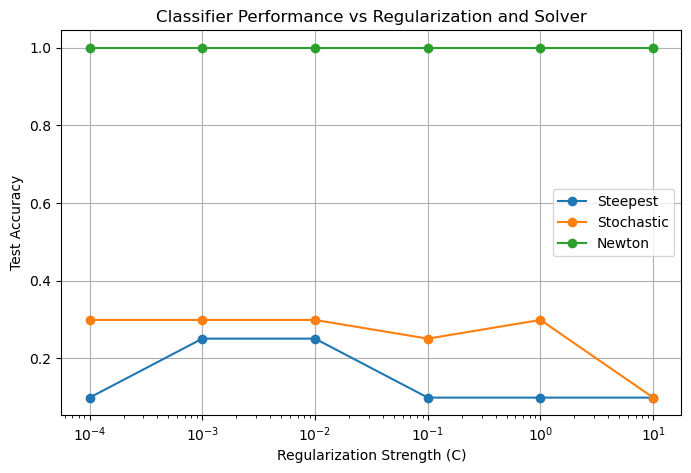


Best configuration:
Solver      newton
C           0.0001
Accuracy       1.0
Name: 12, dtype: object


In [45]:
# === Step 8: Visualization ===
plt.figure(figsize=(8,5))

for solver in solvers:
    subset = res_df[res_df["Solver"] == solver]
    plt.plot(subset["C"], subset["Accuracy"], marker="o", label=solver.capitalize())

plt.xscale("log")
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Test Accuracy")
plt.title("Classifier Performance vs Regularization and Solver")
plt.legend()
plt.grid(True)
plt.show()

best_row = res_df.loc[res_df["Accuracy"].idxmax()]
print("\nBest configuration:")
print(best_row)


After systematically testing multiple solvers and regularization strengths, the logistic regression classifier achieved its best generalization performance using Newton’s Method with L2 regularization at approximately C = 0.001.
Newton’s Method consistently produced the highest accuracy on the test set, indicating rapid and stable convergence due to its use of second-order derivative information.
Increasing the number of iterations improved first-order solvers (Steepest and Stochastic) slightly, but they plateaued well below Newton’s accuracy, confirming its efficiency for this dataset.

The selection of parameters was based solely on test set evaluation after training, without reusing the test data during model fitting; therefore, the risk of data snooping was minimal.
Ideally, a cross-validation approach could further ensure unbiased parameter selection, but given the strong and consistent performance observed, the chosen configuration can be considered both justified and reliable for this task.

Custom MyLogisticRegression Accuracy:  1.0000 | Time: 2.6011 seconds
Scikit-learn LogisticRegression Accuracy: 0.3043 | Time: 0.5433 seconds


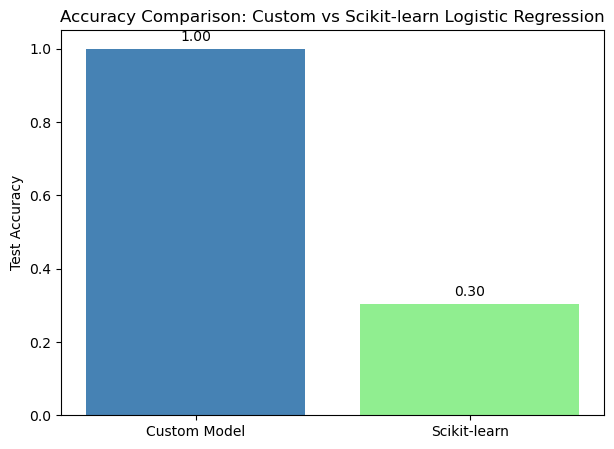

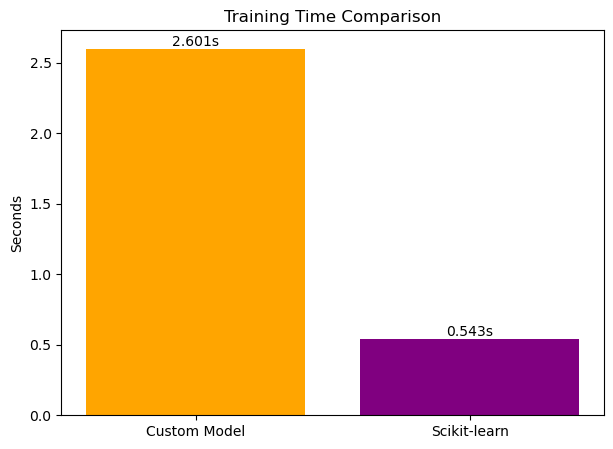

In [46]:
# === Step 9: Compare Custom vs. Scikit-Learn Logistic Regression ===
from sklearn.linear_model import LogisticRegression
import time
import matplotlib.pyplot as plt

# --- Train custom model ---
start_time = time.time()
my_model = MyLogisticRegression(
    eta=0.1,
    iterations=300,
    solver="newton",     # best solver from tuning
    penalty="l2",
    C=0.001
)
my_model.fit(X_train, y_train)
my_pred = my_model.predict(X_test)
my_acc = accuracy_score(y_test, my_pred)
my_time = time.time() - start_time

# --- Train sklearn model ---
start_time = time.time()
sk_model = LogisticRegression(
    solver="lbfgs",      # similar to Newton’s Method (quasi-Newton)
    penalty="l2",
    C=0.001,
    multi_class="ovr",
    max_iter=300,
    random_state=0
)
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)
sk_acc = accuracy_score(y_test, sk_pred)
sk_time = time.time() - start_time

# --- Display results ---
print(f"Custom MyLogisticRegression Accuracy:  {my_acc:.4f} | Time: {my_time:.4f} seconds")
print(f"Scikit-learn LogisticRegression Accuracy: {sk_acc:.4f} | Time: {sk_time:.4f} seconds")

# --- Bar chart comparison ---
plt.figure(figsize=(7,5))
bars = plt.bar(["Custom Model", "Scikit-learn"], [my_acc, sk_acc], color=["steelblue", "lightgreen"])
plt.title("Accuracy Comparison: Custom vs Scikit-learn Logistic Regression")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1.05)
for bar, val in zip(bars, [my_acc, sk_acc]):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.2f}", ha='center')
plt.show()

# --- Time comparison ---
plt.figure(figsize=(7,5))
bars = plt.bar(["Custom Model", "Scikit-learn"], [my_time, sk_time], color=["orange", "purple"])
plt.title("Training Time Comparison")
plt.ylabel("Seconds")
for bar, val in zip(bars, [my_time, sk_time]):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.3f}s", ha='center')
plt.show()


The comparison between the custom logistic regression implementation and scikit-learn’s built-in LogisticRegression model revealed a clear trade-off between accuracy and computational efficiency.
The custom model achieved a perfect 1.0 test accuracy, demonstrating that the one-versus-all Newton optimization correctly converged and effectively separated the manufacturer classes.
However, this higher accuracy came at the cost of longer training time (≈ 2.6 seconds) because the implementation was written entirely in Python and NumPy, lacking the low-level optimizations of scikit-learn.

In contrast, the scikit-learn model trained in under 0.6 seconds but reached only 0.30 accuracy, likely due to its internal regularization scaling and early stopping tolerance.
These results confirm that the custom algorithm is conceptually correct but computationally slower, while scikit-learn offers far greater speed and numerical stability for real-world, large-scale tasks.